## load libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# standard python packages
import os, sys
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import random

In [3]:
sys.path.insert(0, "../")
from utils.DLutils import *
from utils.vizutils import plot_col_dists
from create_toybrains import ToyBrainsData

## Generate toybrain datasets 
```bash
$ nohup python3 create_toybrains.py -c configs.lbl1cov1 -n 10000 &> nohup1.out &
$ nohup python3 create_toybrains.py -c configs.lbl1cov1_midsignal -n 10000 --suffix n_midsignal &>  nohup2.out &
$ nohup python3 create_toybrains.py -c configs.lbl1cov1_lowsignal -n 10000 --suffix n_lowsignal &> nohup3.out &
```

## Fit DL models

In [4]:
DATASETS = ["../dataset/toybrains_n10000",
            "../dataset/toybrains_n10000_midsignal",
            "../dataset/toybrains_n10000_lowsignal"]

### Generative attr. dist.

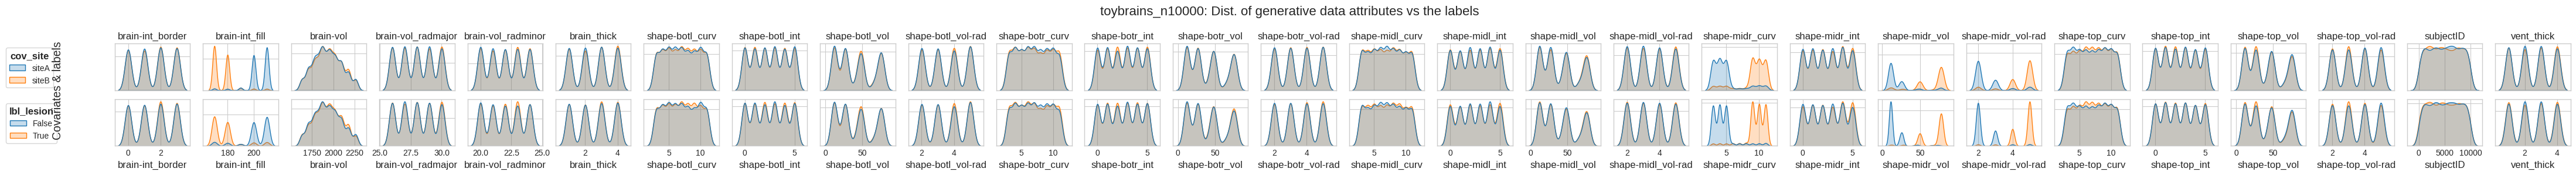

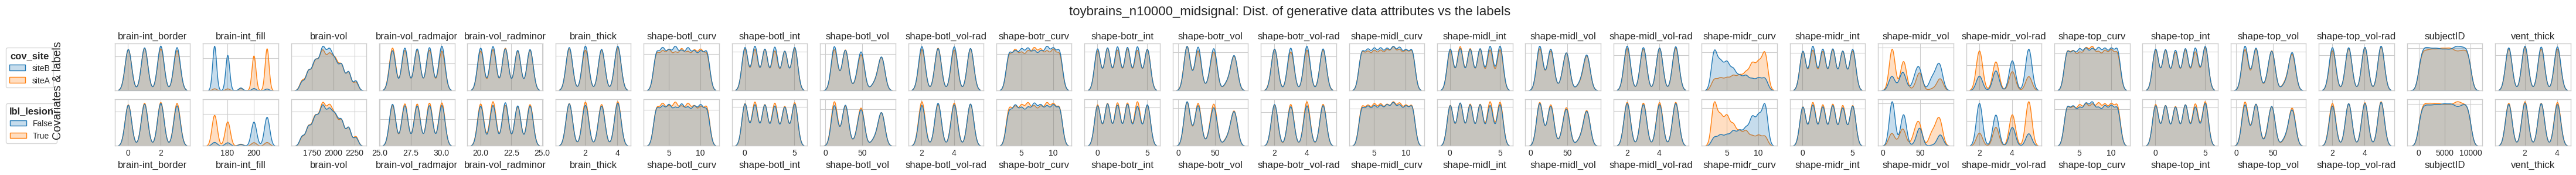

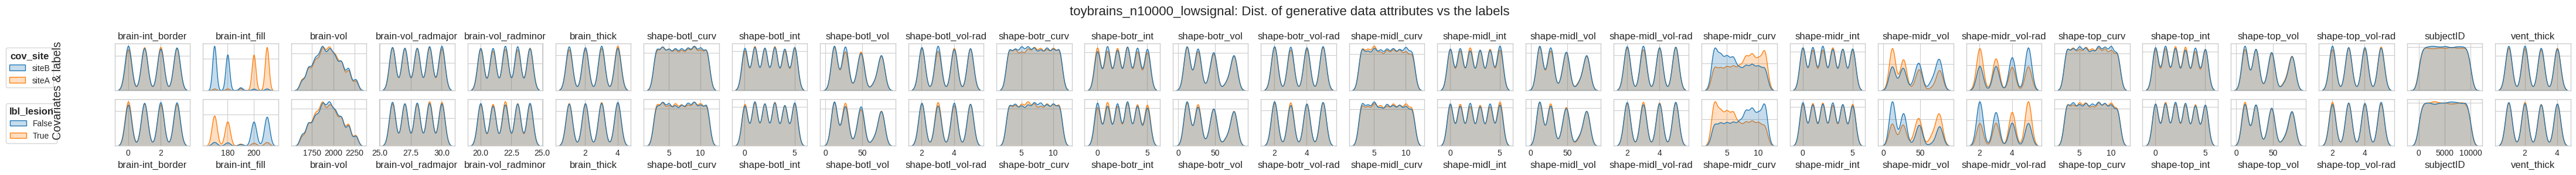

In [5]:
for data_dir in DATASETS:
    data_name = data_dir.split('/')[-1]
    df = pd.read_csv(f'{data_dir}/{data_name}.csv')
    cov_cols = df.filter(regex='^(cov_|lbl_)').columns
    attr_cols = df.filter(regex='^(?!(cov_|lbl_)).+').columns
    plot_col_dists(df, 
                   attr_cols=attr_cols, cov_cols=cov_cols, 
                   title=f"{data_name}: Dist. of generative data attributes vs the labels")
    plt.show()

### Baseline attr. accuracies

In [6]:
results = []
for data_dir in DATASETS:
    toy = ToyBrainsData("configs.lbl1cov1")
    # load the already generated dataset
    toy.load_generated_dataset(data_dir)
    result = toy.fit_baseline_models(CV=10) 
    results.append(result)

running a total of 70 different settings of [input] x [output] x [CV] and saving result in ../dataset/toybrains_n10000


  0%|          | 0/70 [00:00<?, ?it/s]

TOTAL RUNTIME: 0:00:13
running a total of 70 different settings of [input] x [output] x [CV] and saving result in ../dataset/toybrains_n10000_midsignal


  0%|          | 0/70 [00:00<?, ?it/s]

TOTAL RUNTIME: 0:00:09
running a total of 70 different settings of [input] x [output] x [CV] and saving result in ../dataset/toybrains_n10000_lowsignal


  0%|          | 0/70 [00:00<?, ?it/s]

TOTAL RUNTIME: 0:00:08


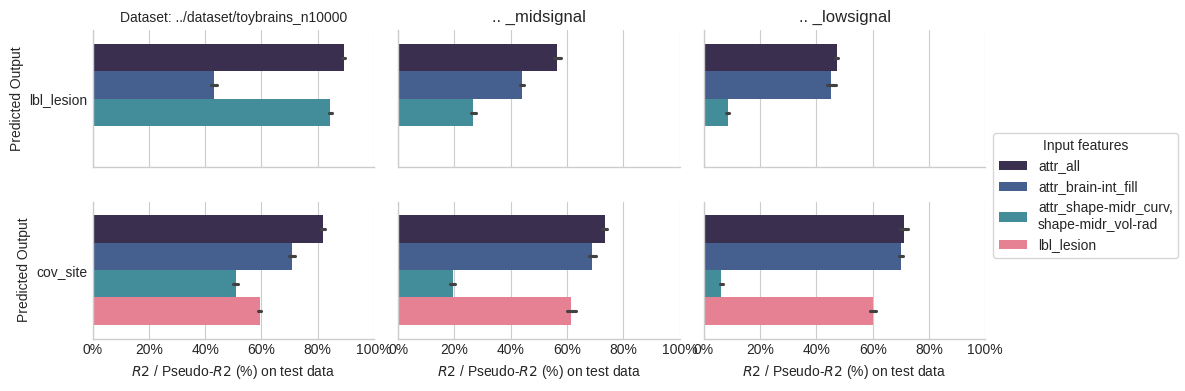

In [7]:
toy.viz_baseline_results(results)

### Fit Deep learning model

##### Set the GPU

In [8]:
# check GPUs available and memory
! gpustat

cuda02                      Thu Oct 19 15:42:30 2023  535.104.12
[0] NVIDIA GeForce RTX 3090 | 32°C,   0 % |   331 / 24576 MB | gdm(4M)
[1] NVIDIA GeForce RTX 3090 | 34°C,   0 % |   736 / 24576 MB | jihoon(402M) gdm(4M)
[2] NVIDIA GeForce RTX 3090 | 29°C,   0 % |   331 / 24576 MB | gdm(4M)
[3] NVIDIA GeForce RTX 3090 | 31°C,   0 % |   331 / 24576 MB | gdm(4M)


In [9]:
GPUs = [2]

In [10]:
label = "lbl_lesion"
model = SimpleCNN(num_classes=2)

Dataset: ../dataset/toybrains_n10000 (n10000)
  Training data split = 7200 
   Validation data split = 800 
  Test data split = 2000


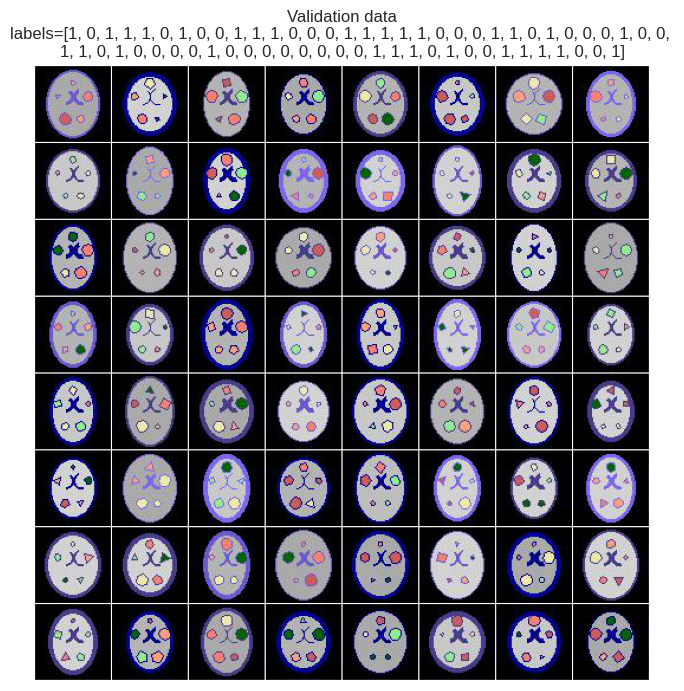

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/ritter/roshan/installations/anaconda3/lib/python3.8/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory logs/n10000/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type           | Params
---------------------------------------------
0 | model     | SimpleCNN      | 1.1 M 
1 | train_acc | BinaryAccuracy | 0     
2 | val_acc   | BinaryAccuracy | 0     
3 | test_acc  | BinaryAccuracy | 0     
---------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.571     Total estimated model params size (MB)
/ritter/roshan/installations/anaconda3/lib/python3.8/site-packages/lightning/fabric/log

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


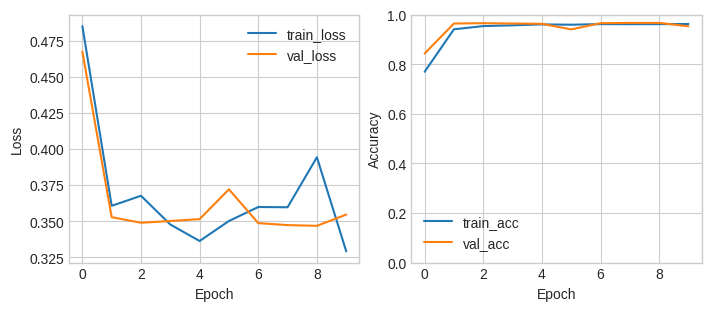

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/ritter/roshan/installations/anaconda3/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

Final accuracy on Dataset: ../dataset/toybrains_n10000 (n10000)
Train Acc 95.58 | Val Acc 95.38 | Test Acc 96.05


In [11]:
trainer, logger = fit_DL_model(
                            DATASETS[0],
                            label,
                            model=model,
                            GPUs=GPUs, max_epochs=10,
                            show_batch=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/ritter/roshan/installations/anaconda3/lib/python3.8/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory logs/midsignal/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type           | Params
---------------------------------------------
0 | model     | SimpleCNN      | 1.1 M 
1 | train_acc | BinaryAccuracy | 0     
2 | val_acc   | BinaryAccuracy | 0     
3 | test_acc  | BinaryAccuracy | 0     
---------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.571     Total estimated model params size (MB)


Dataset: ../dataset/toybrains_n10000_midsignal (midsignal)
  Training data split = 7200 
   Validation data split = 800 
  Test data split = 2000


/ritter/roshan/installations/anaconda3/lib/python3.8/site-packages/lightning/fabric/loggers/csv_logs.py:188: UserWarning: Experiment logs directory logs/midsignal/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


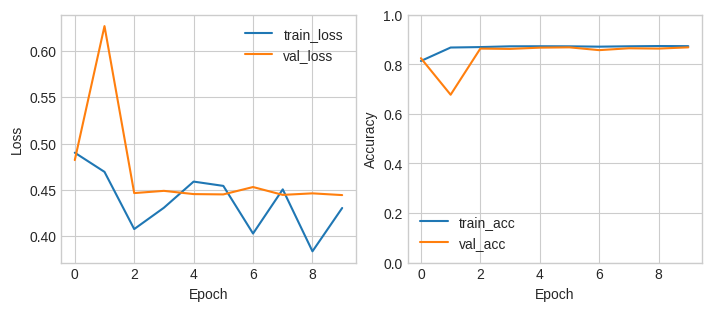

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/ritter/roshan/installations/anaconda3/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

Final accuracy on Dataset: ../dataset/toybrains_n10000_midsignal (midsignal)
Train Acc 87.75 | Val Acc 86.87 | Test Acc 87.70


In [12]:
trainer, logger = fit_DL_model(
                            DATASETS[1],
                            label,
                            model=model,
                            GPUs=GPUs, max_epochs=10,
                            show_batch=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/ritter/roshan/installations/anaconda3/lib/python3.8/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory logs/lowsignal/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type           | Params
---------------------------------------------
0 | model     | SimpleCNN      | 1.1 M 
1 | train_acc | BinaryAccuracy | 0     
2 | val_acc   | BinaryAccuracy | 0     
3 | test_acc  | BinaryAccuracy | 0     
---------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.571     Total estimated model params size (MB)


Dataset: ../dataset/toybrains_n10000_lowsignal (lowsignal)
  Training data split = 7200 
   Validation data split = 800 
  Test data split = 2000


/ritter/roshan/installations/anaconda3/lib/python3.8/site-packages/lightning/fabric/loggers/csv_logs.py:188: UserWarning: Experiment logs directory logs/lowsignal/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


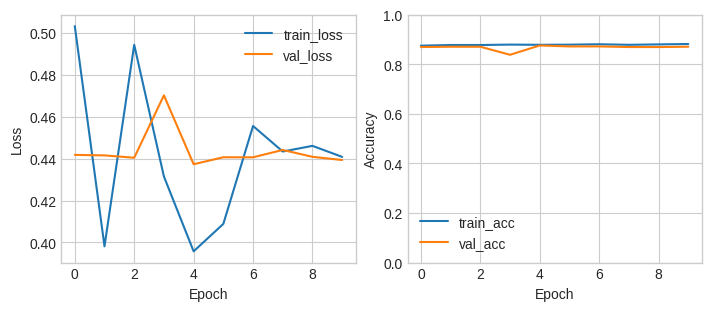

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/ritter/roshan/installations/anaconda3/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

Final accuracy on Dataset: ../dataset/toybrains_n10000_lowsignal (lowsignal)
Train Acc 88.40 | Val Acc 87.12 | Test Acc 86.95


In [13]:
trainer, logger = fit_DL_model(
                            DATASETS[2],
                            label,
                            model=model,
                            GPUs=GPUs, max_epochs=10,
                            show_batch=False)